In [1]:
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, Dense, TimeDistributed
from tensorflow.keras.optimizers import RMSprop

import matplotlib.pyplot as plt

### Import Data

In [2]:
df = pd.read_csv(r'.\data\stock_prices_sample.csv')
df = df[df.TICKER != 'GEF']
df = df[df.TYPE != 'Intraday']
df.reset_index(drop = True, inplace =True)

### Defining Inputs

In [3]:
TRAIN_SPLIT=700

LOOK_BACK_WINDOW = 90
NUM_OF_FUTURE_PREDICTION = 60


BATCH_SIZE = 128
EPOCHS = 10
EVALUATION_INTERVAL = 20
VALIDATION_INTERVAL = 10

### Data preprocessing

In [4]:
features_considered = ["OPEN", "HIGH", "LOW", "CLOSE"]
features = df[features_considered]

In [5]:

data = features.values
print(data.shape)
data_min = data.min(axis=0)
data_max_min_diff = data.max(axis=0)-data_min
dataset = (data - data_min)/data_max_min_diff


(995, 4)


In [6]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size):
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        data.append(dataset[indices])
        labels.append(target[i:i+target_size])
    return np.array(data), np.array(labels)

In [7]:
x_train, y_train = multivariate_data(dataset=dataset
                                     , target=dataset[:,[0,3]]
                                     , start_index=0
                                     , end_index=TRAIN_SPLIT
                                     , history_size=LOOK_BACK_WINDOW
                                     , target_size=NUM_OF_FUTURE_PREDICTION)

x_val, y_val = multivariate_data(dataset=dataset
                                 , target=dataset[:,[0,3]]
                                 , start_index=TRAIN_SPLIT
                                 , end_index=None
                                 , history_size=LOOK_BACK_WINDOW
                                 , target_size=NUM_OF_FUTURE_PREDICTION)

print("shape of x_train:", x_train.shape)
print("shape of y_train:", y_train.shape)
print("shape of x_val:", x_val.shape)
print("shape of y_val:", y_val.shape)

shape of x_train: (610, 90, 4)
shape of y_train: (610, 2, 2)
shape of x_val: (203, 90, 4)
shape of y_val: (203, 2, 2)


### RNN LSTM Encoder & Decoder Network

In [8]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=x_train.shape[-2:]))
model.add(RepeatVector(y_train.shape[1]))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(y_train.shape[2])))

model.compile(optimizer=RMSprop(clipvalue=1.0), loss='mse')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Model Trining

In [9]:
model_history = model.fit(x=x_train, y=y_train
                          , epochs=EPOCHS
                          , steps_per_epoch=EVALUATION_INTERVAL
                          , validation_data=(x_val, y_val)
                          , validation_steps=VALIDATION_INTERVAL)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 20 samples, validate on 203 samples
Epoch 1/10
20/20 [==============================] - 31s 2s/step - loss: 634860110866438946816.0000 - val_loss: 0.0510
Epoch 2/10
20/20 [==============================] - 30s 2s/step - loss: 0.0108 - val_loss: 0.0158
Epoch 3/10
20/20 [==============================] - 31s 2s/step - loss: 0.0042 - val_loss: 0.0107
Epoch 4/10
20/20 [==============================] - 30s 2s/step - loss: 0.0033 - val_loss: 0.0081
Epoch 5/10
20/20 [==============================] - 37s 2s/step - loss: 0.0036 - val_loss: 0.0070
Epoch 6/10
20/20 [==============================] - 29s 1s/step - loss: 0.0040 - val_loss: 0.0067
Epoch 7/10
20/20 [==============================] - 27s 1s/step - loss: 0.0292 - val_loss: 0.0071
Epoch 8/10
20/20 [==============================] - 26s 1s/step - loss: 0.0015 - val_loss: 0.0042
Epoch 9/10
20/20 [==============================] - 27s 1

### Train & CV Error (curve by epoch)

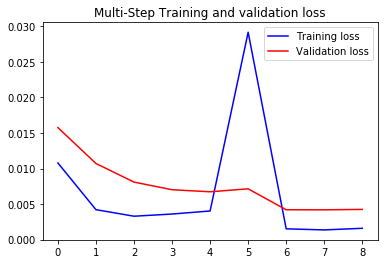

In [10]:
def plot_train_history(history, title):
    loss = history.history['loss'][1:]
    val_loss = history.history['val_loss'][1:]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.show()

plot_train_history(model_history, 'Multi-Step Training and validation loss')


### Model Summary

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               164000    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 2, 200)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 2, 200)            320800    
_________________________________________________________________
time_distributed (TimeDistri (None, 2, 100)            20100     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 2, 2)              202       
Total params: 505,102
Trainable params: 505,102
Non-trainable params: 0
_________________________________________________________________


### Prediction

In [12]:
data_predict = dataset[-90:,:]
data_predict = data_predict.reshape((1, data_predict.shape[0], data_predict.shape[1]))
data_extrapolated = (model.predict(data_predict)[0] * data_max_min_diff[[0,3]]) + data_min[[0,3]]

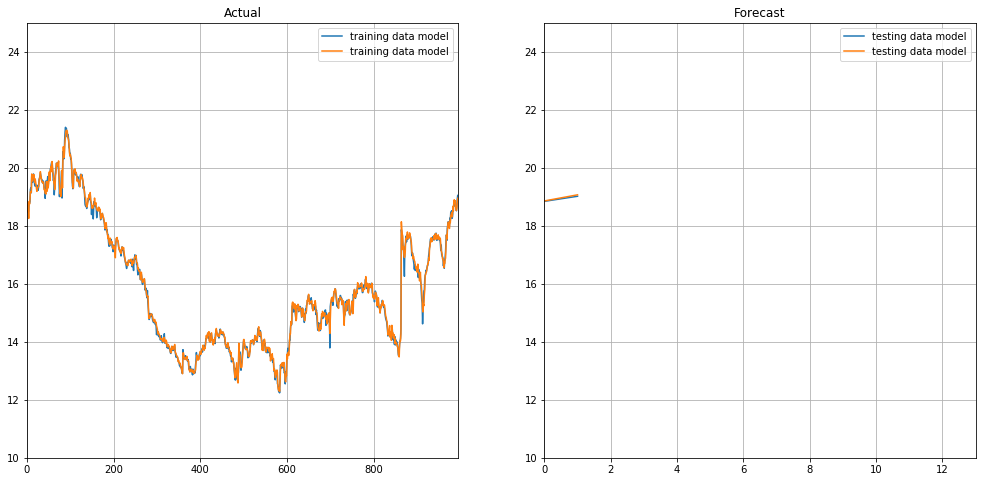

In [13]:
layout = (1,2)
plt.figure(figsize=(17, 8))
plt.subplot2grid(layout, (0,0))
plt.plot(data[:,[0,3]], label='training data model')
plt.axis([0, 995, 10, 25])
plt.legend()
plt.grid(True)
plt.title('Actual')
plt.subplot2grid(layout, (0,1))
plt.plot(data_extrapolated, label='testing data model')
plt.title('Forecast')
plt.axis([0, 13, 10, 25])
plt.legend()
plt.grid(True);